In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import os
from datetime import datetime
import sys

sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
import polars as pl
from tqdm import tqdm

In [22]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu_df.csv"))
_sk_df["time"] = _sk_df["time"].apply(lambda x: datetime.fromtimestamp(x))



In [2]:
_pth = r'D:\CMC\DeepVision\recorded_data\validation\skimu3_30_4_random_1m_0\imu01.csv'

timeoffset = 0.0
_imu_df = pl.read_csv(_pth)

dt = _imu_df["mils"].diff().mean()/1000
dt = 0.011
filter_size = 101
filter_order = 9
_mean_gx = _imu_df["gx"][:filter_size ].mean()
_mean_gy = _imu_df["gy"][:filter_size ].mean()
_mean_gz = _imu_df["gz"][:filter_size ].mean()
_mean_ax = _imu_df["ax"][:filter_size ].mean()
_mean_ay = _imu_df["ay"][:filter_size ].mean()
_mean_az = _imu_df["az"][:filter_size ].mean()

# subtracting mean from gyro
_imu_df = _imu_df.with_columns([
    (pl.col("gx") - _mean_gx).alias("gx"),
    (pl.col("gy") - _mean_gy).alias("gy"),
    (pl.col("gz") - _mean_gz).alias("gz"),
])

# subtracting mean from accel
_imu_df = _imu_df.with_columns([
    (pl.col("ax") - _mean_ax).alias("ax"),
    (pl.col("ay") - _mean_ay).alias("ay"),
    (pl.col("az") - _mean_az).alias("az"),
])

# apply savgol filter
_imu_df = _imu_df.with_columns([
                        pl.col("ax").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("ay").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                        pl.col("az").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                    ])

_imu_df = _imu_df.with_columns([
                (pl.col("gx").cumsum()*dt * 9.81).alias("ang_x"),
                (pl.col("gy").cumsum()*dt * 9.81).alias("ang_y"),
                (pl.col("gz").cumsum()*dt * 9.81).alias("ang_z"),
            ])

_imu_df = _imu_df.with_columns(pl.col("sys_time").str.to_datetime().alias("time"))
_imu_df = _imu_df.with_columns(pl.col("time").map(lambda x: x + timedelta(seconds=timeoffset)).alias("time"))

#change string to float
_imu_df = _imu_df.with_columns(pl.col("mz\r").str.replace("\r","").cast(pl.Float64).alias("mz"))

In [3]:
_imu_df = _imu_df.to_pandas()

In [4]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [10]:
def validation(df):
    # columns =['gyrox1','gyroy1','gyroz1','accelx1','accely1','accelz1','Time']
    # df = pd.read_csv(imu_file, usecols=columns)

    # _acceleration_filter_window = 101
    # _acceleration_filter_order = 9
    # _gyro_filter_window = 81
    # _gyro_filter_order = 9

    # # df.ax = savgol_filter(df.ax, _acceleration_filter_window, _acceleration_filter_order)
    # # df.ay = savgol_filter(df.ay, _acceleration_filter_window, _acceleration_filter_order)
    # # df.az = savgol_filter(df.az, _acceleration_filter_window, _acceleration_filter_order)
    # # df.gx = savgol_filter(df.gx, _gyro_filter_window, _gyro_filter_order)
    # # df.gy = savgol_filter(df.gy, _gyro_filter_window, _gyro_filter_order)
    # # df.gz = savgol_filter(df.gz, _gyro_filter_window, _gyro_filter_order)

    _gx_offset = 0
    _gy_offset = 0
    _gz_offset = 0
    
    q4=[]
    Q1=[]
    accx1=df.ax
    accy1=df.ay
    accz1=df.az
    angx= df.ang_x 
    angy= df.ang_y 
    angz= df.ang_z 

    ang_comp=[]
    a=0.02
    for j in range(len(angx)):
        norm=np.linalg.norm([angx[j],angy[j],angz[j]]) 
        axis_of_rot=[angx[j]/norm,angy[j]/norm,angz[j]/norm]
        theta= 0.01*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q_comp=[q0,q1,q2,q3]
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
        q4.append(q_comp)
    s_comp=q4[0]
    for j in range(len(q4)):
        dummy=s_comp
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq51=[s_comp[0]/normq5,s_comp[1]/normq5,s_comp[2]/normq5,s_comp[3]/normq5]
        invq5=[invq51[0],-1*invq51[1],-1*invq51[2],-1*invq51[3]]
        qupdat1=quaternion_multiply(s_comp,Q1[j])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=[qupdate[0]/norm1,qupdate[1]/norm1,qupdate[2]/norm1,qupdate[3]/norm1]
        rot_ax=np.cross(new_qup[1:],init)
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=(np.dot(new_qup[1:],init))/((np.linalg.norm(new_qup[1:])*np.linalg.norm(init)))
        theta=np.arccos(thet)
        q0=math.cos(a*theta/2)
        q1=(axis_of_rot[0])*math.sin(a*theta/2)
        q2=(axis_of_rot[1])*math.sin(a*theta/2)
        q3=(axis_of_rot[2])*math.sin(a*theta/2)
        qt=[q0,q1,q2,q3]
        s=quaternion_multiply(s_comp,q4[j])
        s_comp=quaternion_multiply(qt,s)
        finaltheta=np.rad2deg(2*np.arccos(s_comp[0]))
        ang_comp.append(finaltheta)
    
    IMU=ang_comp
    return IMU

In [11]:
_imu =  validation(_imu_df)

In [12]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(1)
_om = get_marker_name(3)

# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df.time

NameError: name '_base_pth' is not defined

In [13]:
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

NameError: name '_mocap_df' is not defined

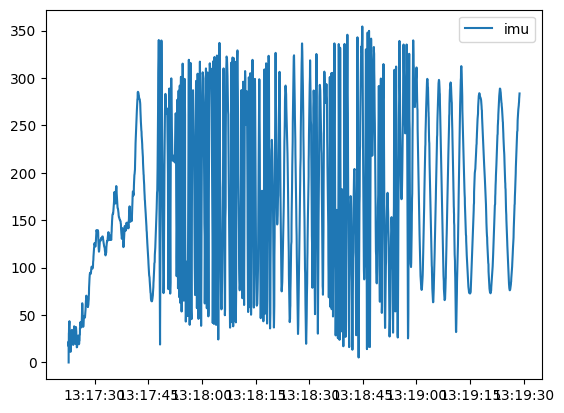

In [14]:
plt.plot(_imu_df.time[:], _imu[:], label="imu")
# plt.plot(_m_df["time"][:], abs(_theta_z[:]), label="mc")
plt.legend()